# Example 8

The work developed in [1] presents a multiscale 3D chemotaxis assay by combining high-throughput 3D bacterial tracking with microfluidically created chemical gradients. The authors study a large dataset of 3D trajectories of bacteria, analysing statistical properties of the ensemble.

This example shows how to use yupi in order to inspect the dataset of the aforementioned work. It focuses on reproducing some of the figures of the original paper focusing on showcasing yupi API for data processing and visualization for the case of 3D trajectories.


## 1. Import dependencies

In [1]:
import tarfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from pathlib import Path

from utils.binner import Binner

from yupi.core import JSONSerializer
from yupi.graphics import plot_3d, plot_angles_hist
from yupi.stats import collect

## 2. Uncompress and load the dataset

We downloaded the original dataset from [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/7DF0AT). Then, we converted it into yupi trajectories while keeping just a subset of the whole dataset which we stored in the `ecoli_trajs.tar.zx` file. We can load the trajectories as:


In [2]:
tar = tarfile.open('resources/data/ecoli_trajs.tar.xz', 'r:xz')
tar.extractall(".")
all_trajs = []
bulk_trajs = []
for file in Path().glob("Ecoli*.json"):
    _loaded_trajs = JSONSerializer.load_ensemble(str(file))
    all_trajs.extend(_loaded_trajs)
    if "bulk"in file.name:
        bulk_trajs.extend(_loaded_trajs)

## 3. Plotting trajectories

We can easily inspect the trajectories in a single plot, partially reproducing the Figure 1b of the original paper: 

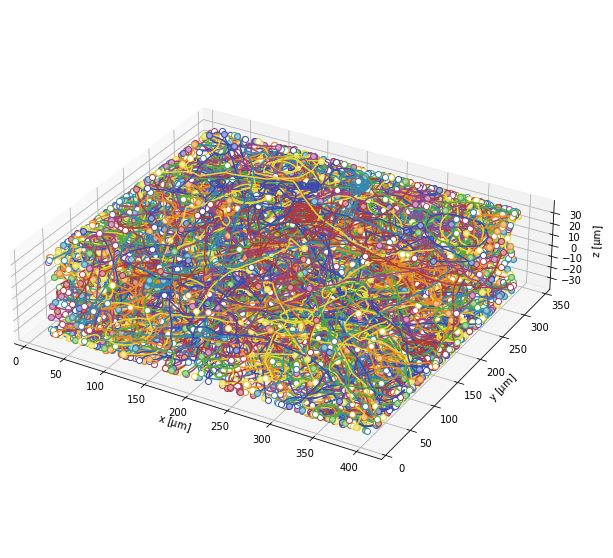

In [3]:
plt.figure(figsize=(14, 10))
ax = plot_3d(all_trajs[:2000], legend=False, units='$\mathrm{\mu m}$', show=False)
ax.set_box_aspect((400, 350, 100))

## 4. Inspecting a single trajectory

Figure 1c from the original paper.

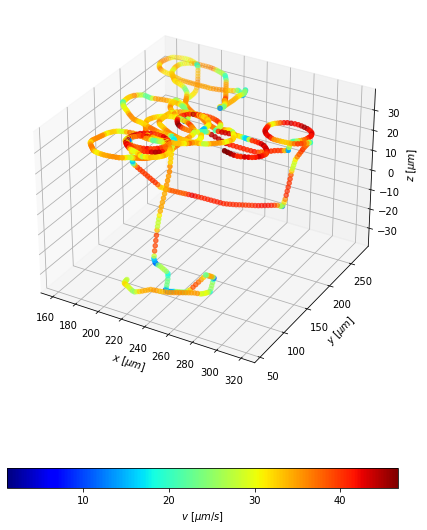

In [4]:
plt.figure(figsize=(14, 10))
traj = all_trajs[1057]
lbls = '${}~[{}]$'

ax = plt.axes(projection='3d')
x = ax.scatter(traj.r.x, traj.r.y, traj.r.z, c=traj.v.norm, cmap='jet')
plt.colorbar(x, location='bottom', label=lbls.format('v', '\mu m/s'), shrink=.5)
ax.update({f'{n}label': lbls.format(n, '\mu m') for n in 'xyz'})
plt.show()

## 5. Analysis of the velocity distribution according to z-axis position

Figure 1d of the original paper

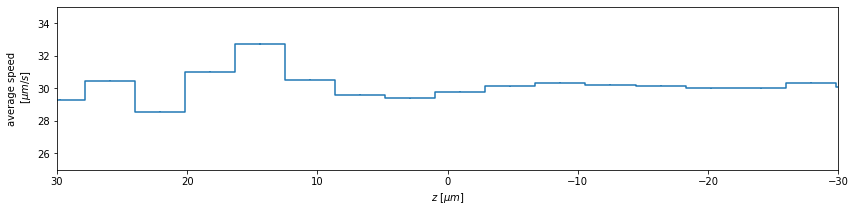

In [5]:
fixed_trajs = [traj.copy() for traj in all_trajs]
for traj in fixed_trajs:
    traj.rotate_3d(np.pi, (0, 1, 0))
z = collect(fixed_trajs, func=lambda r: r.z)
v = collect(fixed_trajs, velocity=True, func=lambda v: v.norm)

bn = Binner(z, v, count=22)
plt.figure(figsize=(14, 3))
ax = plt.subplot()
plt.errorbar(bn.center_bins, bn.y_binned_mean, yerr=bn.y_binned_sem, drawstyle='steps-mid')
plt.ylim(25, 35)
plt.xlim(-30, 30)
ax.invert_xaxis()
plt.xlabel(lbls.format('z', '\mu m'))
plt.ylabel('average speed\n' + lbls.format("", '\mu m/s'))
plt.show()

## 5. Computing angles

Next, we can partially reproduce the figure 1e from the original paper by:

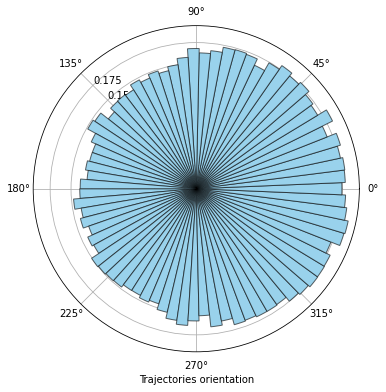

In [8]:
fixed_bulk_trajs = [traj.copy() for traj in bulk_trajs]
for traj in fixed_bulk_trajs:
    traj -= traj.r[0]
    traj.rotate_3d(np.pi, (0, 1, 0))

plt.figure(figsize=(10, 6))
xy_vel = collect(fixed_bulk_trajs, func=lambda v: v[:,:2], velocity=True)
angles = np.array([np.arctan2(v[1], v[0]) for v in xy_vel])
ax = plot_angles_hist(angles, bins=75, show=False)
ax.set_theta_zero_location("E")
plt.xlabel("Trajectories orientation")
plt.show()

## 7. References

[1] Grognot, M., & Taute, K. M. (2021). A multiscale 3D chemotaxis assay reveals bacterial navigation mechanisms. Communications biology, 4(1), 1-8.